# Lecture 11: Introduction to Differential Programming with JAX

# Overview
1. Python basics (Numpy)
2. JAX basics
3. Lorenz system
4. JAX-FEM

# 1. Python basics

In [18]:
import jax
import jax.numpy as np
from jax import random
from jax.flatten_util import ravel_pytree
import numpy as onp
from functools import partial
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
from functools import partial

## 2. JAX

## 2.1 Just-in-time compilation (JIT): `jit`

In order to speed up your code, you can use the `jit` decorator, which will cached your operation. Let's compare the speed with and without `jit`.

In [19]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * np.where(x > 0, x, alpha * np.exp(x) - alpha)

key = random.PRNGKey(0)
x = random.normal(key, (1000000,))
%timeit selu(x).block_until_ready()

3.45 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
selu_jit = jax.jit(selu)
%timeit selu_jit(x).block_until_ready()

552 µs ± 63.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## 2.2 Automatic differentiation: `grad`

Taking the gradient in JAX is pretty easy, you just need to call the `grad` function from the JAX library. Let's begin with a simple example that is calculating the grad of $x^2$. From calculus, we know that:

$$
\frac{\partial x^2}{\partial x} = 2 x
$$

$$
\frac{\partial^2 x^2}{\partial x^2} = 2
$$

$$
\frac{\partial^3 x^2}{\partial x^3} = 0
$$


In [23]:
square = lambda x: np.square(x)

grad_square = jax.grad(square)
grad_grad_square = jax.grad(jax.grad(square))
grad_grad_grad_square = jax.grad(jax.grad(jax.grad(square)))
print(f"grad 2² = ", grad_square(2.))
print(f"grad grad 2² = ", grad_grad_square(2.))
print(f"grad grad grad 2² = ", grad_grad_grad_square(2.))

grad 2² =  4.0
grad grad 2² =  2.0
grad grad grad 2² =  0.0


## 2.3 Vectorizing map: `vmap`

`vmap`, or vectorizing map, maps a function along array axes, having better performance mainly when is composed with `jit`. Let's apply this for matrix-vector products.

# 4. Lorenz system

We will study the numerical solutions of Lorenz system using **explicit** and **implicit** Euler methods. 
Then, we will show how to compute the derivatives.

## 4.1. Lorenz System Definition
The Lorenz system is defined by three coupled nonlinear ODEs:

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma(y - x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $ \mathbf{y} = [x, y, z]^T $ is the state vector, and $ \sigma, \rho, \beta $ are system parameters.

In [2]:
# Define Lorenz system RHS
def lorenz_rhs(state, params):
    rho, sigma, beta = params
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return np.array([dxdt, dydt, dzdt])

## 4.2 Explicit Euler Method

The explicit Euler method approximates:

$$
\mathbf{y}_{n+1} = \mathbf{y}_n + \Delta t \cdot \mathbf{f}(\mathbf{y}_n, t_n)
$$

For the Lorenz system:

$$
\begin{aligned}
x_{n+1} &= x_n + \Delta t[\sigma(y_n - x_n)] \\
y_{n+1} &= y_n + \Delta t[x_n(\rho - z_n) - y_n] \\
z_{n+1} &= z_n + \Delta t[x_n y_n - \beta z_n]
\end{aligned}
$$

**Note**: The explicit Euler updating scheme fits into the framework we discussed in Lecture 10:
$$
\begin{aligned}
\boldsymbol{U}^{n} = \boldsymbol{F}(\boldsymbol{U}^{n-1}, \boldsymbol{\Theta})
\end{aligned}
$$
where $\boldsymbol{U}^{n}=\mathbf{y}_n$ and $\boldsymbol{\Theta}=[\sigma, \rho, \beta]$

Final state: [-9.108915 -8.420388 28.648304]


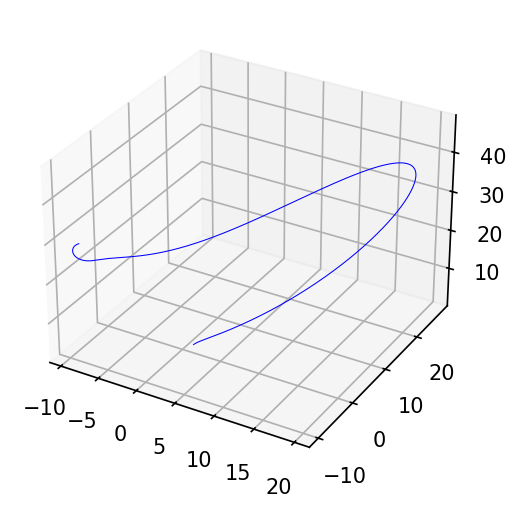

In [3]:
# Explicit euler integration scheme
@jax.jit
def explicit_euler(y_current, params):
    y_next = y_current + dt * lorenz_rhs(y_current, params)
    return y_next

# Integration function
def integrate_lorenz_explicit(y0, params):  
    ys = []
    y = y0
    for i in range(num_steps):
        # print(f"i = {i}")
        y = explicit_euler(y, params)
        ys.append(y)
    ys = np.array(ys)
    return y, ys

# Integration parameters
dt = 0.001
# total_time = 1.0
total_time = 1.
num_steps = int(total_time / dt)

# Lorenz system parameters
params = np.array([28.0, 10.0, 8.0/3.0])  # rho, sigma, beta
# Initial conditions
y0 = np.array([1.0, 1.0, 1.0])

yf, ys = integrate_lorenz_explicit(y0, params)
print("Final state:", yf)

# Visualize the results
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(projection='3d')
x0, x1, x2 = ys.T
ax.plot(x0, x1, x2, lw=0.5, color='b')

## 4.3 Implicit Euler Method


The implicit Euler method solves:

$$
\mathbf{y}_{n+1} = \mathbf{y}_n + \Delta t \cdot \mathbf{f}(\mathbf{y}_{n+1}, t_{n+1})
$$

This results in a nonlinear system to solve at each step:

$$
\mathbf{F}(\mathbf{y}_{n+1}) = \mathbf{y}_{n+1} - \mathbf{y}_n - \Delta t \cdot \mathbf{f}(\mathbf{y}_{n+1}) = 0
$$

**Newton-Raphson Iteration**

Solve $ \mathbf{F}(\mathbf{y}_{n+1}) = 0 $ using:

$$
\mathbf{y}_{n+1}^{(k+1)} = \mathbf{y}_{n+1}^{(k)} - [J_F(\mathbf{y}_{n+1}^{(k)})]^{-1} \mathbf{F}(\mathbf{y}_{n+1}^{(k)})
$$

Where the Jacobian $ J_F $ is:

$$
J_F = I - \Delta t \cdot J(\mathbf{y}_{n+1}^{(k)})
$$

The term $ J(\mathbf{y}) = \frac{\partial \mathbf{f}}{\partial \mathbf{y}} $ for Lorenz system:

$$
J(\mathbf{y}) = \begin{bmatrix}
-\sigma & \sigma & 0 \\
\rho - z & -1 & -x \\
y & x & -\beta
\end{bmatrix}
$$

Remark: We can use AD to compute this Jacobian.

**Note**: The implicit Euler updaing scheme fits into the framework we discussed in Lecture 10:
$$
\begin{aligned}
\boldsymbol{U}^{n} &= \boldsymbol{U}^n(\boldsymbol{U}^{n-1}, \boldsymbol{\Theta})
\end{aligned}
$$
where the implicit relation is defined through the following residual function:
$$
\begin{aligned}
\boldsymbol{R}(\boldsymbol{U}^{n}, \boldsymbol{U}^{n-1}, \boldsymbol{\Theta})&=\boldsymbol{0}
\end{aligned}
$$

Final state: [-9.657035 -8.349896 30.017582]


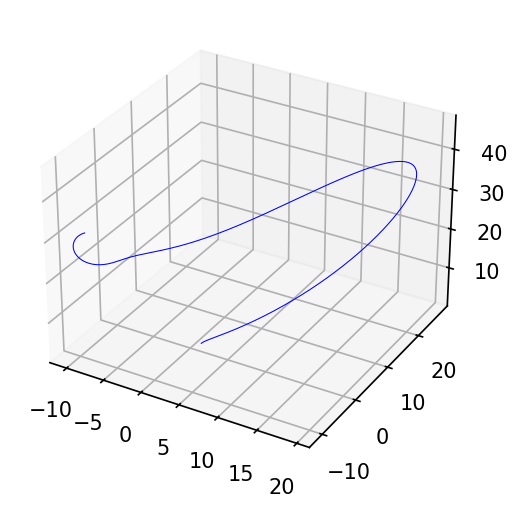

In [4]:
# Residual function R
def residual(y_next, y_current, param):
    return y_next - y_current - dt * lorenz_rhs(y_next, params)

@jax.jit
def implicit_euler(y_current, params):

    # Initial guess using explicit Euler
    y_guess = y_current + dt * lorenz_rhs(y_current, params)
    
    # Initialize loop state: (iteration, y_guess, residual_norm, converged)
    init_state = (np.array(0, dtype=np.int32), y_guess, np.array(np.inf, dtype=np.float32))

    def cond_fn(state):
        iteration, _, residual_norm = state
        max_iters=100
        tol=1e-8
        return (iteration < max_iters) & (residual_norm > tol)

    def body_fn(state):
        iteration, y, _ = state
        F = residual(y, y_current, params)
        J = jax.jacfwd(residual)(y, y_current, params)
        delta = np.linalg.solve(J, -F)
        y_new = y + delta
        residual_norm = np.linalg.norm(F)
        return iteration + 1, y_new, residual_norm

    # Run Newton iterations
    final_state = jax.lax.while_loop(cond_fn, body_fn, init_state)
    y_next = final_state[1]
    
    return y_next

# Integration function
def integrate_lorenz_implicit(y0, params):  
    ys = []
    y = y0
    for i in range(num_steps):
        # print(f"i = {i}")
        y = implicit_euler(y, params)
        ys.append(y)
    ys = np.array(ys)
    return y, ys
    
# Integration parameters
dt = 0.001
# total_time = 1.0
total_time = 1.
num_steps = int(total_time / dt)

# Perform integration
yf, ys = integrate_lorenz_implicit(y0, params)
print("Final state:", yf)

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(projection='3d')
x0, x1, x2 = ys.T
ax.plot(x0, x1, x2, lw=0.5, color='b')

## 4.4 Derivatives for explicit Euler

Let $L(\boldsymbol{U}^{0}, \boldsymbol{\Theta})$ be the objective function depending on both initial value $\boldsymbol{U}^{0}$ and parameters $\boldsymbol{\Theta}$. 

The goal is to find the total derivative $\frac{dL}{d\boldsymbol{U}^{0}}$ and $\frac{dL}{d\boldsymbol{\Theta}}$.

In JAX, you can directly call `jax.grad` since everything is explicit.

You may need to use `jax.checkpoint` if memory is an issue.

In [5]:
def loss_explicit(y0, params):
    yf, _ = integrate_lorenz_explicit(y0, params)
    return np.sum(yf**2) + np.sum(params**2)

grad_ad = jax.grad(loss_explicit, argnums=(0, 1))(y0, params)
print(f"AD derivative = {grad_ad}")

AD derivative = (Array([-11.741967, -10.74918 ,  38.72791 ], dtype=float32), Array([ 70.40908 ,  22.952963, 340.35278 ], dtype=float32))


In [6]:
h = 1e-3
val_minus = loss_explicit(y0.at[0].add(-h), params)
val_plus = loss_explicit(y0.at[0].add(h), params)
grad_fd = (val_plus - val_minus)/(2*h)
print(f"FD derivative = {grad_fd}")

FD derivative = -12.084959983825684


In [7]:
val_minus = loss_explicit(y0, params.at[2].add(-h))
val_plus = loss_explicit(y0, params.at[2].add(h))
grad_fd = (val_plus - val_minus)/(2*h)
print(f"FD derivative = {grad_fd}")

FD derivative = 340.9423522949219


## 4.5 Derivatives for implicit Euler

Let $L(\boldsymbol{U}^{0}, \boldsymbol{\Theta})$ be the objective function depending on both initial value $\boldsymbol{U}^{0}$ and parameters $\boldsymbol{\Theta}$. 

The goal is to find the total derivative $\frac{dL}{d\boldsymbol{U}^{0}}$ and $\frac{dL}{d\boldsymbol{\Theta}}$.

In this implicit senario, directly calling `jax.grad` is a bad practice since it will differentiate through the internal loops of Newton's method. 

In [8]:
def loss_implicit(y0, params):
    yf, _ = integrate_lorenz_implicit(y0, params)
    return np.sum(yf**2) + np.sum(params**2)

# Differentiation through the internal loops (bad practice)
# This should be avoided due to efficiency, even if you use fori_loop and make the code run with a correct returning value.
# grad_ad = jax.grad(loss_implicit, argnums=(0, 1))(y0, params)

The good practice is to use the adjoint method and define customized VJP for the update function, as we discussed in Lecture 10. 

In [12]:
# Define custom VJP for the function fwd
def ad_wrapper(fwd):
    @jax.custom_vjp
    def fwd_wrapped(y_current, params):
        y_next = fwd(y_current, params)
        return y_next

    def f_fwd(y_current, params):
        y_next = fwd_wrapped(y_current, params)
        return y_next, (y_next, y_current, params)

    @jax.jit
    def f_bwd(res, v):
        # print("Running backward and solving the adjoint problem...")
        y_next, y_current, params = res
        J = jax.jacfwd(residual)(y_next, y_current, params)
        adjoint = np.linalg.solve(J.T, -v)
        primals_out, f_vjp = jax.vjp(lambda y_current, params: residual(y_next, y_current, params), y_current, params)
        vjp_y_current, vjp_params = f_vjp(adjoint)
        return vjp_y_current, vjp_params

    fwd_wrapped.defvjp(f_fwd, f_bwd)
    return fwd_wrapped

# implicit_euler_wrapped will follow the user-defined behavior for reverse-mode AD
implicit_euler_wrapped = ad_wrapper(implicit_euler)

# Redefine the integration function using implicit_euler_wrapped
def integrate_lorenz_implicit_wrapped(y0, params):  
    ys = []
    y = y0
    for i in range(num_steps):
        # print(f"i = {i}")
        y = implicit_euler_wrapped(y, params)
        ys.append(y)
    ys = np.array(ys)
    return y, ys

# Redefine the loss function using integrate_lorenz_implicit_wrapped
def loss_implicit_wrapped(y0, params):
    yf, _ = integrate_lorenz_implicit_wrapped(y0, params)
    return np.sum(yf**2) + np.sum(params**2)
    
grad_ad = jax.grad(loss_implicit_wrapped, argnums=(0, 1))(y0, params)
print(f"AD derivative = {grad_ad}")

AD derivative = (Array([-28.137827, -23.98648 ,  40.719566], dtype=float32), Array([56.       , 20.       ,  5.3333335], dtype=float32))


In [10]:
h = 1e-3
val_minus = loss_implicit_wrapped(y0.at[2].add(-h), params)
val_plus = loss_implicit_wrapped(y0.at[2].add(h), params)
grad_fd = (val_plus - val_minus)/(2*h)
print(f"FD derivative = {grad_fd}")

FD derivative = 40.710445404052734


In [11]:
val_minus = loss_implicit_wrapped(y0, params.at[2].add(-h))
val_plus = loss_implicit_wrapped(y0, params.at[2].add(h))
grad_fd = (val_plus - val_minus)/(2*h)
print(f"FD derivative = {grad_fd}")

FD derivative = 5.249022960662842
